In [1]:
from rdflib import Graph, URIRef
from rdflib.namespace import RDF, OWL
from rdflib.plugins.sparql import prepareQuery

import matplotlib.pyplot as plt

import re

In [2]:
# Algunas constantes
BASE = "http://smartcity.linkeddata.es/airQuality/"
BASE_RECURSOS = BASE + "resources/"

SCHEMA = "http://schema.org/"
SOSA = "http://www.w3.org/ns/sosa/" # No debe estar actualizado el prefijo rdflib.namespace, pues SOSA devuelve la URI de SSN
GEO = "http://www.w3.org/2003/01/geo/wgs84_pos#"

BASE_PATH = "Curso2020201/VictorManuelTenorioGomez/linkedData/"

# Lectura de los grafos

Vamos a realizar la carga de los datos en la variable 'g', que contendrá todos los datos de nuestro conjunto. Para ello haremos uso de la función `parse` de la librería rdflib

In [3]:
g = Graph()
g.parse(BASE_PATH + "Estaciones-Calidad-del-Aire.rdf")
g.parse(BASE_PATH + "Magnitudes-Calidad-del-Aire.rdf")
g.parse(BASE_PATH + "Sensores-Calidad-del-Aire.rdf")
g.parse(BASE_PATH + "Mediciones-Calidad-del-Aire.rdf")

 http://www.w3.org/ns/sosa/ does not look like a valid URI, trying to serialize this will break.
 http://www.w3.org/ns/sosa/ does not look like a valid URI, trying to serialize this will break.
 http://www.w3.org/ns/sosa/ does not look like a valid URI, trying to serialize this will break.
 http://www.w3.org/ns/sosa/ does not look like a valid URI, trying to serialize this will break.


<Graph identifier=Ndd1f09cbba3e425996796b45875c4545 (<class 'rdflib.graph.Graph'>)>

# Queries iniciales

La siguiente celda, que retorna todas las tripletas del grafo, está convertida en texto plano (celda tipo "Raw") para evitar la gran cantidad de datos que devuelve.

Por hacer una prueba, vamos a realizar una consulta al grafo. Para ello, consultaremos en primer lugar todas las tripletas que tengan como objeto la URI de la ciudad de Alcobendas, que únicamente será la estación situada en este mismo municipio. Si hubiese más estaciones en Alcobendas, nos quedaríamos con la última que retorne la función `triples`.

Posteriormente, vamos a ver todas las propiedades de esta estación, buscando para ello todas las tripletas que la tengan como sujeto.

In [4]:
alcobendas = URIRef(BASE_RECURSOS + "towns#Alcobendas")
for s, p, o in g.triples((None, None, alcobendas)):
    print("{} - {} - {}".format(s, p, o))
print("Ended - " + str(s)) # La variable s contiene el recurso de la estación de Alcobendas (solo hay una tripleta)
for s2, p, o in g.triples((s, None, None)):
    print("{} - {} - {}".format(s2, p, o))

http://smartcity.linkeddata.es/airQuality/resources/stations/28006004 - http://schema.org/location - http://smartcity.linkeddata.es/airQuality/resources/towns#Alcobendas
Ended - http://smartcity.linkeddata.es/airQuality/resources/stations/28006004
http://smartcity.linkeddata.es/airQuality/resources/stations/28006004 - http://smartcity.linkeddata.es/airQuality/ontology#tipoEstacion - Tráfico
http://smartcity.linkeddata.es/airQuality/resources/stations/28006004 - http://smartcity.linkeddata.es/airQuality/ontology#tipoLocalizacion - Urbana
http://smartcity.linkeddata.es/airQuality/resources/stations/28006004 - http://smartcity.linkeddata.es/airQuality/ontology#fechaAlta - 2000-01-19
http://smartcity.linkeddata.es/airQuality/resources/stations/28006004 - http://www.w3.org/2003/01/geo/wgs84_pos#lat - 40°32'25,8"N
http://smartcity.linkeddata.es/airQuality/resources/stations/28006004 - http://schema.org/location - http://smartcity.linkeddata.es/airQuality/resources/towns#Alcobendas
http://sma

Podríamos serializar el grafo con la siguiente sentendia, pero debido a la gran cantidad de datos almacenados actualmente en el grafo, he preferido convertir la celda a texto plano por claridad.

# Representación de los datos en un mapa

Vamos a representar la localización de las estaciones en un mapa. Para ello vamos a buscar todos aquellos objetos que tengan las propiedades `geo:lat` y `geo:long` mediante la función `triples`, que sé que únicamente serán las estaciones, y nos quedaremos con el objeto de las tripletas.

Adicionalmente tendremos que convertir el string que representa grados, minutos y segundos a valores decimales, esto lo haré mediante la función `to_dec` que se basa en una expresión regular.

Por último, represesentaremos los datos sobre la imagen del mapa, obtenida de OpenStreetMaps.

In [5]:
def to_dec(coord_str):
    if 'S' in coord_str or 'W' in coord_str:
        sign = -1
    else:
        sign = 1
    regex = re.search(r"(\d+)°(\d+)\'(.+)(\'\'|\")", coord_str)
    deg = float(regex.groups()[0])
    mins = float(regex.groups()[1])
    sec = float(regex.groups()[2].replace(',', '.'))
    return sign * (deg + mins/60 + sec/3600)

In [6]:
# Obtenemos la latitud y la longitud de todos los puntos
lat_URI = URIRef(GEO + 'lat')
long_URI = URIRef(GEO + 'long')

coord_data = {}
for s, p, o in g.triples((None, lat_URI, None)):
    coord_data[str(s)] = {"lat": to_dec(str(o))}

for s, p, o in g.triples((None, long_URI, None)):
    coord_data[str(s)]['long'] = to_dec(str(o))

lats = [d['lat'] for d in coord_data.values()]
longs = [d['long'] for d in coord_data.values()]

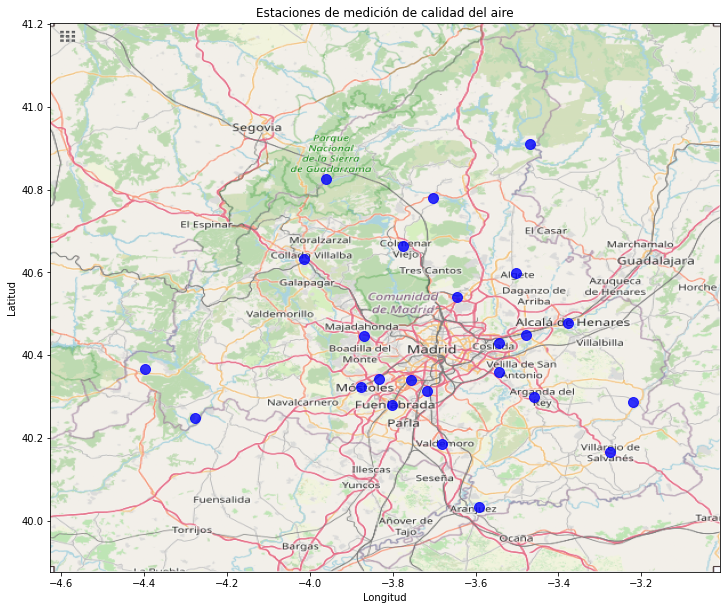

In [7]:
madrid = plt.imread('madrid.png')

#Límites obtenidos al obtener la imagen de openstreetmaps
BBox = [-4.6252, -3.0103, 39.8781, 41.2014]

fig, ax = plt.subplots(figsize = (12,12))

ax.scatter(longs, lats, zorder=1, alpha= 0.8, c='b', s=100)

ax.set_title('Estaciones de medición de calidad del aire')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

ax.imshow(madrid, zorder=0, extent = BBox, aspect= 'equal')

fig.savefig('localizacion-mapa.png')

# Representación de los datos de O3 frente a la población de cada municipio

En esta aplicación vamos a utilizar la reconciliación realizada para los municipios con los datos de Wikidata, con la intención de obtener su población a partir del SPARQL endpoint de esta fuente. La idea es la representación de los valores de contaminación frente a la población de cada municipio, con la intención de analizar si los municipios con más población son los que mayores valores de contaminación presentan.

## Obtención de los datos de estaciones por municipio

En primer lugar obtendré tanto la URI como el link de wikidata para los municipios donde están situadas cada una de las estaciones, y lo haré de dos formas: en primer lugar iterando sobre el grafo, y en segundo mediante una SPARQL query (el resultado es el mismo).

In [8]:
platformURI = URIRef(SOSA + "Platform")
locationURI = URIRef(SCHEMA + "location")

In [9]:
est_data = {} # Diccionario donde guardaremos los datos de las estaciones

# Hacemos un bucle sobre todas las plataformas,
# y nos quedamos con su atributo schema:location,
# y de este nos quedamos con el atributo referenciado
# por la propiedad owl:sameAs
for est in g.subjects(RDF.type, platformURI):
    for mun in g.objects(est, locationURI):
        for wd in g.objects(mun, OWL.sameAs):
            est_data[str(est)] = {
                'mun_URI': str(mun),
                'wikidata_link': str(wd)
            }

### Lo mismo, pero utilizando una SPARQL Query

In [10]:
init_ns = {
    "rdf": RDF,
    "sosa": SOSA,
    "schema": SCHEMA,
    "owl": OWL
}

query_string = """
SELECT ?b ?c
WHERE {
    ?a rdf:type sosa:Platform .
    ?a schema:location ?b .
    ?b owl:sameAs ?c .
}
"""

q = prepareQuery(query_string, initNs = init_ns)

In [11]:
municipios_sparql = []
wikidata_links_sparql = []
for row in g.query(q):
    municipios_sparql.append(row[0])
    wikidata_links_sparql.append(row[1])

 http://www.w3.org/ns/sosa/ does not look like a valid URI, trying to serialize this will break.


## Obtener población de cada municipio desde Wikidata

En esta subsección utilizaré los links de Wikidata obtenidos para obtener tanto el nombre del municipio como la población del mismo, para cada uno de los municipios obtenidos en el apartado anterior. En este caso, utilizaré la librería SPARQLWrapper de Python para realizar las queries al SPARQL endpoint de Wikidata

In [12]:
from SPARQLWrapper import SPARQLWrapper, JSON

Declaro el SPARQL endpoint de wikidata, la query, y voy ejecutando la query para cada uno de los códigos de municipios. Obtendré de ello tanto la población (propiedad wdt:P1082 de Wikidata) como el nombre del municipio (propiedad wdt:P1448).

In [13]:
wikidata_ep = SPARQLWrapper("http://query.wikidata.org/sparql")

In [14]:
wd_query_string = """
SELECT ?p ?n
WHERE {
  wd:%municipio% wdt:P1082 ?p .
  wd:%municipio% wdt:P1448 ?n .
}
"""

In [15]:
# Recorremos nuestro diccionario de estaciones rellenando los datos del nombre del municipio y su población
for k, v in est_data.items():
    link_wikidata = v['wikidata_link']
    wd_id = link_wikidata[link_wikidata.rfind('/')+1:]
    
    wikidata_ep.setQuery(wd_query_string.replace("%municipio%", wd_id))
    wikidata_ep.setReturnFormat(JSON)
    results = wikidata_ep.query().convert()
    
    municipio_wd = results['results']['bindings'][0]
    est_data[k]['nombre_mun'] = municipio_wd['n']['value']
    est_data[k]['poblacion'] = int(municipio_wd['p']['value'])

## Obteniendo las medidas de O3 de cada estación un día concreto

Elijo una fecha y una hora, por ejemplo, un miércoles a las 6 de la tarde, y unas magnitudes medidas, en este caso O3 (id 14), NO (id 7) y NO2 (id 8). Construyo a partir de ellos las URIs de las mediciones, y hago queries al grafo (con la función `objects`) para obtener los valores de las medidas

In [16]:
# Vamos a elegir un miércoles a las 6 de la tarde
URI_base_O3 = BASE_RECURSOS + 'measurements/{}_14/2020-03-04T18:00Z'
URI_base_NO = BASE_RECURSOS + 'measurements/{}_7/2020-03-04T18:00Z'
URI_base_NO2 = BASE_RECURSOS + 'measurements/{}_8/2020-03-04T18:00Z'

URI_hasSimpleResult = URIRef(SOSA + 'hasSimpleResult')

for est in est_data.keys():
    id_est = est[est.rfind('/')+1:]
    est_data[est]['medida_O3'] = [m.value for m in g.objects(URIRef(URI_base_O3.format(id_est)), URI_hasSimpleResult)][0]
    est_data[est]['medida_NO'] = [m.value for m in g.objects(URIRef(URI_base_NO.format(id_est)), URI_hasSimpleResult)][0]
    est_data[est]['medida_NO2'] = [m.value for m in g.objects(URIRef(URI_base_NO2.format(id_est)), URI_hasSimpleResult)][0]

## Represento población frente a valores de O3

Una vez tengo tanto los datos de población como los de las mediciones, puedo representarlo en una gráfica para analizar el resultado.

In [17]:
municipios = [v['nombre_mun'] for v in est_data.values()]
poblaciones = [v['poblacion'] for v in est_data.values()]
medidas_O3 = [v['medida_O3'] for v in est_data.values()]
medidas_NO = [v['medida_NO'] for v in est_data.values()]
medidas_NO2 = [v['medida_NO2'] for v in est_data.values()]

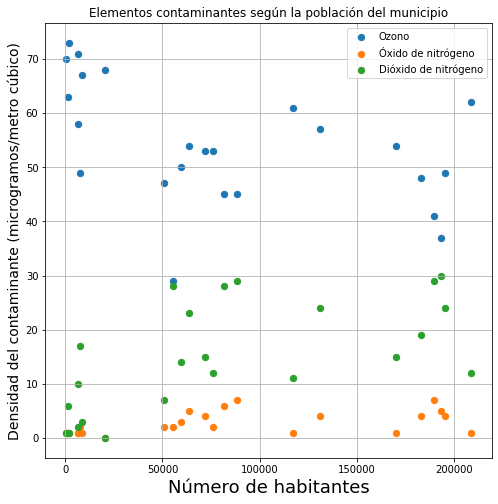

In [18]:
fig = plt.figure(figsize=(8,8))

plt.scatter(poblaciones, medidas_O3, s=40)
plt.scatter(poblaciones, medidas_NO, s=40)
plt.scatter(poblaciones, medidas_NO2, s=40)
#plt.xticks(poblaciones, municipios, rotation=90)
plt.grid()
plt.xlabel("Número de habitantes", fontsize=18)
plt.ylabel("Densidad del contaminante (microgramos/metro cúbico)", fontsize=14)
plt.title("Elementos contaminantes según la población del municipio")
plt.legend(['Ozono', 'Óxido de nitrógeno', 'Dióxido de nitrógeno'])

fig.savefig('pob-medida.png')

plt.show()

Como podemos ver, no parece existir una correlación entre la población de un municipio y los valores de sus mediciones de contaminación.

# Representación de los valores de contaminación a lo largo de un mes

Por último, voy a analizar la influencia del COVID sobre la contaminación en una determinada estación (Alcorcón) y a una determinada hora (las 6 de la tarde). Para ello, voy a analizar los valores de contaminación obtenidos a lo largo del mes de marzo de 2020, cuando se produjo el primer confinamiento, para ver si el mismo provocó una disminución de los valores de contaminación.

Para ello, únicamente tengo que construir las URIs de las mediciones a partir de los valores elegidos y para cada uno de los días del mes, y obtener del grafo los valores de las mediciones (propiedad `sosa:hasSimpleResult`). Después puedo representarlo en la gráfica.

In [23]:
# Construimos las URIs a falta de rellenar el día de la medición
URI_base_O3 = BASE_RECURSOS + 'measurements/28007004_14/2020-03-{:02d}T18:00Z'
URI_base_NO = BASE_RECURSOS + 'measurements/28007004_7/2020-03-{:02d}T18:00Z'
URI_base_NO2 = BASE_RECURSOS + 'measurements/28007004_8/2020-03-{:02d}T18:00Z'

medidas_O3 = []
medidas_NO = []
medidas_NO2 = []

for d in range(1,32):
    medidas_O3.append([m.value for m in g.objects(URIRef(URI_base_O3.format(d)), URI_hasSimpleResult)][0])
    medidas_NO.append([m.value for m in g.objects(URIRef(URI_base_NO.format(d)), URI_hasSimpleResult)][0])
    medidas_NO2.append([m.value for m in g.objects(URIRef(URI_base_NO2.format(d)), URI_hasSimpleResult)][0])

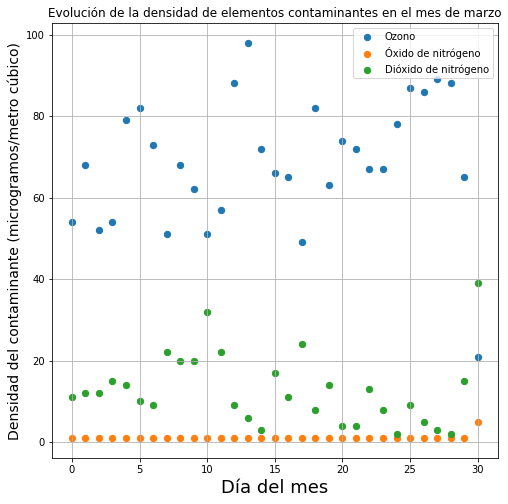

In [24]:
fig = plt.figure(figsize=(8,8))

x = range(len(medidas_O3))

plt.scatter(x, medidas_O3, s=40)
plt.scatter(x, medidas_NO, s=40)
plt.scatter(x, medidas_NO2, s=40)
plt.grid()
plt.xlabel("Día del mes", fontsize=18)
plt.ylabel("Densidad del contaminante (microgramos/metro cúbico)", fontsize=14)
plt.title("Evolución de la densidad de elementos contaminantes en el mes de marzo")
plt.legend(['Ozono', 'Óxido de nitrógeno', 'Dióxido de nitrógeno'])

fig.savefig('medidas-mes.png')

plt.show()

De nuevo, no podemos observar una tendencia a la baja en los valores de contaminación a lo largo del mes, por lo que parece a simple vista que el confinamiento no tuvo un gran efecto en la contaminación durante el mes de marzo. Habría que observar otros meses para ver si este efecto es más pronunciado.